# PPR Dependence

I'm interested in how dramatically the value-based rankings of players change with the points per reception. My guess is that there will be large swings between 0, 0.5 and 1.0 points per reception. The implication would be that one-size fits all rankings are BS.

In [2]:
import os
import pandas as pd

data = pd.read_csv(os.path.join("..", "..", "data", "processed", "Projections-2019.csv"))

data.head()

,key,name,pos,team,bye,std,half_ppr,ppr,kick_extra_points,rush_yds,...,two_pts,pass_tds,df_tds,kick_30_39,df_points_allowed_per_game,fumbles,kick_0_19,rush_tds,kick_50,kick_40_49
0,barkley_RB_NYG,Saquon Barkley,RB,NYG,11.0,1.3,1.0,1.0,NaN,1267.3,...,0.6,NaN,NaN,NaN,NaN,4.0,NaN,9.6,NaN,NaN
1,elliott_RB_DAL,Ezekiel Elliott,RB,DAL,8.0,2.3,2.3,2.6,NaN,1364.5,...,NaN,NaN,NaN,NaN,NaN,2.4,NaN,8.6,NaN,NaN
2,mccaffrey_RB_CAR,Christian McCaffrey,RB,CAR,7.0,2.8,3.3,2.4,NaN,1055.6,...,0.0,NaN,NaN,NaN,NaN,1.8,NaN,6.6,NaN,NaN
3,kamara_RB_NO,Alvin Kamara,RB,NO,9.0,3.8,3.3,4.0,NaN,943.0,...,1.6,NaN,0.1,NaN,NaN,1.8,NaN,9.0,NaN,NaN
4,gordon_RB_LAC,Melvin Gordon,RB,LAC,12.0,5.5,5.7,6.6,NaN,946.5,...,0.5,NaN,NaN,NaN,NaN,2.0,NaN,8.8,NaN,NaN


In [3]:
# create projections for each player

import numpy as np

points = {  # standard ESPN scoring
    "pass_yds": 0.04,
    "pass_tds": 4.0,
    "pass_ints": -2.0,
    "receptions": 0.0,  # the stat that matters here
    "reception_yds": 0.1,
    "reception_tds": 6.0,
    "rush_yds": 0.1,
    "rush_tds": 6.0,
    "fumbles": -2.0,
    "two_pts": 2.0,
    "kick_extra_points": 1.0,
    "kick_0_19": 3.0,
    "kick_20_29": 3.0,
    "kick_30_39": 3.0,
    "kick_40_49": 4.0,
    "kick_50": 5.0,
    "df_ints": 2.0,
    "df_tds": 6.0,
    "df_sacks": 1.0,
    "df_points_allowed_per_game": 0,
    "df_fumbles": 2.0,
    "df_safeties": 2.0,
}

data = data.fillna(0)

for ppr in [0.0, 0.5, 1.0]:
    points["receptions"] = ppr

    proj = "proj-" + str(ppr)  # col name
    data[proj] = data.apply(lambda x: sum(x[col] * pts for col, pts in points.items() if x[col]), axis=1)

data.head()

,key,name,pos,team,bye,std,half_ppr,ppr,kick_extra_points,rush_yds,...,kick_30_39,df_points_allowed_per_game,fumbles,kick_0_19,rush_tds,kick_50,kick_40_49,proj-0.0,proj-0.5,proj-1.0
0,barkley_RB_NYG,Saquon Barkley,RB,NYG,11.0,1.3,1.0,1.0,0.0,1267.3,...,0.0,0.0,4.0,0.0,9.6,0.0,0.0,263.39,304.64,345.89
1,elliott_RB_DAL,Ezekiel Elliott,RB,DAL,8.0,2.3,2.3,2.6,0.0,1364.5,...,0.0,0.0,2.4,0.0,8.6,0.0,0.0,255.28,290.58,325.88
2,mccaffrey_RB_CAR,Christian McCaffrey,RB,CAR,7.0,2.8,3.3,2.4,0.0,1055.6,...,0.0,0.0,1.8,0.0,6.6,0.0,0.0,249.76,296.46,343.16
3,kamara_RB_NO,Alvin Kamara,RB,NO,9.0,3.8,3.3,4.0,0.0,943.0,...,0.0,0.0,1.8,0.0,9.0,0.0,0.0,247.98,292.18,336.38
4,gordon_RB_LAC,Melvin Gordon,RB,LAC,12.0,5.5,5.7,6.6,0.0,946.5,...,0.0,0.0,2.0,0.0,8.8,0.0,0.0,205.44,230.34,255.24


In [4]:
# add value to each player

positions = ["QB", "RB", "WR", "TE", "DST", "K"]

data["std"] = data["std"].astype(float)
data["half_ppr"] = data["half_ppr"].astype(float)
data["ppr"] = data["ppr"].astype(float)
data = data[data["std"] > 0.0]

adp = ["std", "half_ppr", "ppr"]
for i, pts in enumerate(["proj-0.0", "proj-0.5", "proj-1.0"]):
    # map from each position to the numberof players in that position
    # drafted during the first 100 picks of a draft
    # that's the index of the replacement player
    # see: https://www.footballguys.com/05vbdrevisited.htm
    replacement = {}
    for pos in positions:
        replacement[pos] = len(data[(data.pos == pos) & (data[adp[i]] <= 100.0)])
        
    print(pts, replacement)

    replace_pts = {}
    data = data.sort_values(pts, ascending=False)
    for pos, ind in replacement.items():
        replace_pts[pos] = data[data.pos == pos][ind:ind+1][pts].values[0]
                                                              
    value = pts + "-value"
    data[value] = data.apply(lambda x: x[pts] - replace_pts[x["pos"]], axis=1)
    
data.head()

proj-0.0 {'QB': 10, 'RB': 39, 'WR': 38, 'TE': 10, 'DST': 1, 'K': 0}
proj-0.5 {'QB': 12, 'RB': 47, 'WR': 45, 'TE': 12, 'DST': 8, 'K': 5}
proj-1.0 {'QB': 10, 'RB': 38, 'WR': 37, 'TE': 10, 'DST': 1, 'K': 0}


,key,name,pos,team,bye,std,half_ppr,ppr,kick_extra_points,rush_yds,...,kick_0_19,rush_tds,kick_50,kick_40_49,proj-0.0,proj-0.5,proj-1.0,proj-0.0-value,proj-0.5-value,proj-1.0-value
0,barkley_RB_NYG,Saquon Barkley,RB,NYG,11.0,1.3,1.0,1.0,0.0,1267.3,...,0.0,9.6,0.0,0.0,263.390,304.640,345.890,166.090,208.73,216.090
2,mccaffrey_RB_CAR,Christian McCaffrey,RB,CAR,7.0,2.8,3.3,2.4,0.0,1055.6,...,0.0,6.6,0.0,0.0,249.760,296.460,343.160,152.460,200.55,213.360
22,mahomes_QB_KC,Patrick Mahomes,QB,KC,12.0,25.0,26.0,25.2,0.0,222.0,...,0.0,2.4,0.0,0.0,342.912,342.912,342.912,53.222,54.41,53.222
3,kamara_RB_NO,Alvin Kamara,RB,NO,9.0,3.8,3.3,4.0,0.0,943.0,...,0.0,9.0,0.0,0.0,247.980,292.180,336.380,150.680,196.27,206.580
1,elliott_RB_DAL,Ezekiel Elliott,RB,DAL,8.0,2.3,2.3,2.6,0.0,1364.5,...,0.0,8.6,0.0,0.0,255.280,290.580,325.880,157.980,194.67,196.080


91
QB -4.0
RB 3.5
WR -0.5
TE -6.0
DST -5.0
K nan
0.0-rank 0.799431248260644
0.5-rank 0.7363444491674789
1.0-rank 0.7873088370164485


,name,pos,adp-std,adp-ppr,0.0-rank,0.5-rank,1.0-rank,diff
59,Tarik Cohen,RB,63.0,58.0,75,55,52,-23
27,Zach Ertz,TE,28.5,24.8,41,38,24,-17
11,Michael Thomas,WR,12.8,10.6,33,22,16,-17
61,James White,RB,63.3,56.0,55,47,40,-15
15,Travis Kelce,TE,15.8,15.0,21,20,7,-14
84,Vance McDonald,TE,90.5,96.8,98,99,85,-13
63,Jarvis Landry,WR,68.0,62.8,74,59,63,-11
81,Will Fuller,WR,84.3,83.0,82,82,94,12
79,Robby Anderson,WR,82.3,77.2,70,72,83,13
32,Marlon Mack,RB,32.5,35.2,25,32,38,13


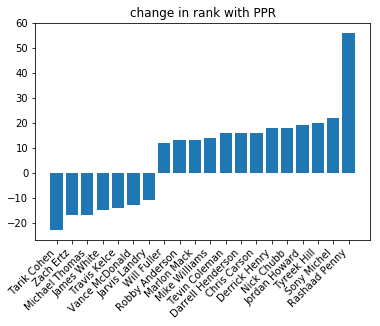

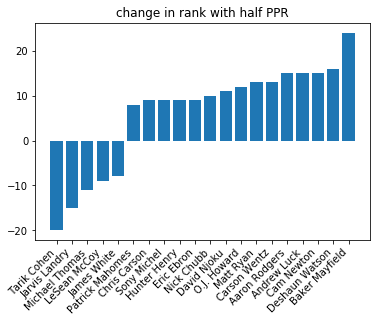

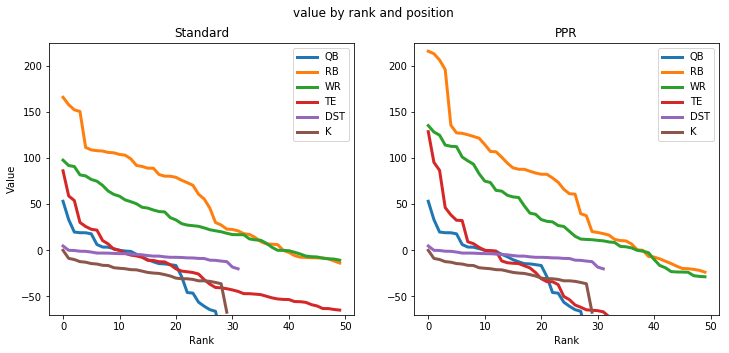

In [11]:
#### add ranks, sort and print top 50 players

from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

adp = ["std", "half_ppr", "ppr"]
ranks = ["0.0-rank", "0.5-rank", "1.0-rank"]
vals = ["proj-0.0-value", "proj-0.5-value", "proj-1.0-value"]

for rank, val in zip(ranks, vals):
    data = data.sort_values(val, ascending=False)
    data[rank] = np.arange(len(data)) + 1

data["diff"] = data[ranks[2]] - data[ranks[0]]
data["abs_diff"] = abs(data["diff"])
data["half_diff"] = data[ranks[1]] - data[ranks[0]]
data["half_abs_diff"] = abs(data["half_diff"])

data["adp-std"] = data["std"]
data["adp-ppr"] = data["ppr"]


data = data.sort_values("0.0-rank", ascending=True)

top_100 = data[((data["std"] <= 100) | (data["ppr"] <= 100)) & ((data[ranks[0]] <= 100) | (data[ranks[2]] <= 100))]
print(len(top_100))

for pos in positions:
    print(pos, top_100[top_100.pos == pos]["diff"].median())

for p, r in zip(adp, ranks):
    print(r, r2_score(top_100[r], top_100[p]))
    
cols = ["name", "pos", "adp-std", "adp-ppr"] + ranks + ["diff"]
top_100.sort_values("diff", ascending=True)[cols].to_csv("top_100.csv", index=False)
large_diff = top_100.sort_values("abs_diff", ascending=False)[:20].sort_values("diff", ascending=True)
large_diff[cols].to_csv("top_20.csv", index=False)

plt.figure()
plt.bar(np.arange(len(large_diff)), large_diff["diff"])
plt.xticks(np.arange(len(large_diff)), large_diff["name"], rotation=45, ha="right")
plt.gca().set_title("change in rank with PPR")
plt.savefig('change_in_rank.png', bbox_inches='tight');

large_diff_half = top_100.sort_values("half_abs_diff", ascending=False)[:20].sort_values("half_diff", ascending=True)
plt.figure()
plt.bar(np.arange(len(large_diff_half)), large_diff_half["half_diff"])
plt.xticks(np.arange(len(large_diff_half)), large_diff_half["name"], rotation=45, ha="right")
plt.gca().set_title("change in rank with half PPR")
plt.savefig('change_in_rank_half_ppr.png', bbox_inches='tight');

pos_to_val_std = {}
for pos in positions:
    pos_to_val_std[pos] = data[data.pos == pos].sort_values("proj-0.0-value", ascending=False)["proj-0.0-value"].values

pos_to_val_ppr = {}
for pos in positions:
    pos_to_val_ppr[pos] = data[data.pos == pos].sort_values("proj-1.0-value", ascending=False)["proj-1.0-value"].values

plt.figure(figsize=(12, 5)).suptitle("value by rank and position")
plt.subplot(1, 2, 1)
for pos, vals in pos_to_val_std.items():
    cutoff = 50 if 50 <= len(vals) else len(vals)
    vals = vals[:cutoff]
    plt.plot(np.arange(len(vals)), vals, label=pos, lw=3)

plt.gca().legend()
plt.gca().set_ylim(-70, 225)
plt.gca().set_title("Standard")
plt.gca().set_ylabel("Value")
plt.gca().set_xlabel("Rank")

plt.subplot(1, 2, 2)
for pos, vals in pos_to_val_ppr.items():
    cutoff = 50 if 50 <= len(vals) else len(vals)
    vals = vals[:cutoff]
    plt.plot(np.arange(len(vals)), vals, label=pos, lw=3)
    
plt.gca().legend()
plt.gca().set_ylim(-70, 225)
plt.gca().set_title("PPR")
plt.gca().set_xlabel("Rank")
plt.savefig('value_by_position.png', bbox_inches='tight');

large_diff[cols]
